# Generate Figures for Thesis

This notebook generates publication-quality figures from experiment results.

**Author:** Gheith Alrawahi  
**Institution:** Nankai University

---


In [1]:
# Cell 1: Imports and Setup
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from config import RESULTS_DIR, FIGURES_DIR

# Style settings for publication-quality figures
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    'font.size': 12,
    'font.family': 'serif',
    'axes.labelsize': 14,
    'axes.titlesize': 14,
    'legend.fontsize': 11,
    'xtick.labelsize': 11,
    'ytick.labelsize': 11,
    'figure.figsize': (10, 6),
    'figure.dpi': 150,
    'savefig.dpi': 300,
    'savefig.bbox': 'tight',
    'lines.linewidth': 2,
})

# Color palette
COLORS = {
    'teacher': '#1f77b4',          # Blue
    'teacher_v4': '#17a2b8',       # Cyan (V4 Teacher)
    'v1_baseline': '#9b59b6',      # Purple
    'v2_enhanced': '#2ecc71',      # Green (Best)
    'v3_dkd_beta8': '#e74c3c',     # Red (Failed)
    'v3_1_dkd_beta2': '#f39c12',   # Orange
    'v4_cross_res': '#3498db',     # Blue
}

LABELS = {
    'teacher': 'Teacher 32x32 (EfficientNetV2-L)',
    'teacher_v4': 'Teacher 64x64 (EfficientNetV2-L)',
    'v1_baseline': 'v1: Baseline',
    'v2_enhanced': 'v2: Standard KD',
    'v3_dkd_beta8': 'v3: DKD (β=8.0)',
    'v3_1_dkd_beta2': 'v3.1: DKD (β=2.0)',
    'v4_cross_res': 'v4: Cross-Resolution',
}

print(f"Results directory: {RESULTS_DIR}")
print(f"Figures directory: {FIGURES_DIR}")

Results directory: d:\Projects\KnowledgeDistillation\code_v2_32\results
Figures directory: d:\Projects\KnowledgeDistillation\code_v2_32\figures


In [2]:
# Cell 2: Load All Results (Updated for new structure)
def load_experiment_results(exp_dir: Path):
    """Load results for a single experiment from directory."""
    results = {}
    
    # Load final results (check multiple possible filenames)
    for final_name in ['final_results.json', 'final_results_teacher.json', 'final_results_v4.json']:
        final_path = exp_dir / final_name
        if final_path.exists():
            with open(final_path, 'r') as f:
                results['final'] = json.load(f)
            break
    
    # Load training history
    history_path = exp_dir / 'training_history.csv'
    if history_path.exists():
        results['history'] = pd.read_csv(history_path)
    
    # Load config (for student experiments)
    config_path = exp_dir / 'config.json'
    if config_path.exists():
        with open(config_path, 'r') as f:
            results['config'] = json.load(f)
    
    return results

def find_experiment_dir(base_id: str) -> Path:
    """Find experiment directory (handles timestamped directories)."""
    # First check exact match
    exact_path = RESULTS_DIR / base_id
    if exact_path.exists():
        return exact_path
    
    # Search for timestamped directories
    matching_dirs = list(RESULTS_DIR.glob(f"{base_id}_*"))
    if matching_dirs:
        # Return most recent
        return sorted(matching_dirs)[-1]
    
    return None

# Load Teacher results (32x32)
experiments = {}
teacher_dir = RESULTS_DIR / 'teacher'
if teacher_dir.exists():
    experiments['teacher'] = load_experiment_results(teacher_dir)
    print(f"✓ Loaded: teacher (32x32)")
else:
    print(f"✗ Not found: teacher")

# Load Teacher V4 results (64x64)
teacher_v4_dir = RESULTS_DIR / 'teacher_v4'
if teacher_v4_dir.exists():
    experiments['teacher_v4'] = load_experiment_results(teacher_v4_dir)
    print(f"✓ Loaded: teacher_v4 (64x64)")
else:
    print(f"✗ Not found: teacher_v4")

# Load Student experiments (updated: v4_saturation -> v4_cross_res mapping)
student_experiments_dirs = ['v1_baseline', 'v2_enhanced', 'v3_dkd_beta8', 'v3_1_dkd_beta2', 'v4_saturation']
student_experiments = ['v1_baseline', 'v2_enhanced', 'v3_dkd_beta8', 'v3_1_dkd_beta2', 'v4_cross_res']

for exp_id, dir_id in zip(student_experiments, student_experiments_dirs):
    exp_dir = find_experiment_dir(dir_id)
    if exp_dir and exp_dir.exists():
        experiments[exp_id] = load_experiment_results(exp_dir)
        print(f"✓ Loaded: {exp_id} ({exp_dir.name})")
    else:
        print(f"✗ Not found: {exp_id}")

print(f"\nLoaded {len(experiments)} experiments")

✓ Loaded: teacher (32x32)
✓ Loaded: teacher_v4 (64x64)
✓ Loaded: v1_baseline (v1_baseline_20251207_143632)
✓ Loaded: v2_enhanced (v2_enhanced_20251208_021230)
✓ Loaded: v3_dkd_beta8 (v3_dkd_beta8_20251208_104226)
✓ Loaded: v3_1_dkd_beta2 (v3_1_dkd_beta2_20251208_132844)
✓ Loaded: v4_cross_res (v4_saturation_20251209_170910)

Loaded 7 experiments


In [3]:
# Cell 3: Create Summary Table (Updated for new structure)
def get_accuracy(exp_data, key='final_accuracy'):
    """Get accuracy from experiment data (handles both old and new structure)."""
    if 'final' not in exp_data:
        return 0
    
    results = exp_data['final'].get('results', {})
    
    # New structure uses 'final_accuracy'
    if key == 'final_accuracy':
        return results.get('final_accuracy', results.get('student_accuracy', 0))
    
    return results.get(key, 0)

def create_summary_table():
    """Create summary table of all experiments."""
    rows = []
    
    # Add Teacher (32x32)
    if 'teacher' in experiments:
        data = experiments['teacher']
        results = data.get('final', {}).get('results', {})
        rows.append({
            'Experiment': 'Teacher (32x32)',
            'Model': 'EfficientNetV2-L',
            'Method': '-',
            'Resolution': '32x32',
            'Accuracy (%)': results.get('final_accuracy', 0),
            'Best Epoch': results.get('best_epoch', 0),
            'Total Epochs': results.get('total_epochs', 0),
            'Time (min)': results.get('training_time_minutes', 0)
        })
    
    # Add Teacher V4 (64x64)
    if 'teacher_v4' in experiments:
        data = experiments['teacher_v4']
        results = data.get('final', {}).get('results', {})
        rows.append({
            'Experiment': 'Teacher (64x64)',
            'Model': 'EfficientNetV2-L',
            'Method': '-',
            'Resolution': '64x64',
            'Accuracy (%)': results.get('final_accuracy', 0),
            'Best Epoch': results.get('best_epoch', 0),
            'Total Epochs': results.get('total_epochs', 0),
            'Time (min)': results.get('training_time_minutes', 0)
        })
    
    # Add Students
    for exp_id in student_experiments:
        if exp_id not in experiments:
            continue
        
        data = experiments[exp_id]
        final = data.get('final', {})
        results = final.get('results', {})
        config = data.get('config', final.get('config', {}))
        
        # Get method from config
        distillation = config.get('distillation', {})
        method = distillation.get('method', 'N/A')
        if method == 'dkd':
            method = f"DKD (β={distillation.get('dkd_beta', 'N/A')})"
        elif method == 'standard_kd':
            method = 'Standard KD'
        
        # Determine resolution based on experiment
        resolution = '64x64→32x32' if exp_id == 'v4_cross_res' else '32x32'
        
        rows.append({
            'Experiment': LABELS.get(exp_id, exp_id),
            'Model': 'EfficientNetV2-S',
            'Method': method,
            'Resolution': resolution,
            'Accuracy (%)': get_accuracy(data),
            'Best Epoch': results.get('best_epoch', 0),
            'Total Epochs': results.get('total_epochs', 0),
            'Time (min)': results.get('training_time_minutes', 0)
        })
    
    df = pd.DataFrame(rows)
    return df

summary_df = create_summary_table()
print("\nExperiment Summary:")
print(summary_df.to_string(index=False))

# Save summary
summary_df.to_csv(RESULTS_DIR / 'experiment_summary.csv', index=False)
print(f"\nSaved: {RESULTS_DIR / 'experiment_summary.csv'}")


Experiment Summary:
          Experiment            Model      Method  Resolution  Accuracy (%)  Best Epoch  Total Epochs  Time (min)
     Teacher (32x32) EfficientNetV2-L           -       32x32         76.65         199           200      389.67
     Teacher (64x64) EfficientNetV2-L           -       64x64         84.39         196           200     1048.90
        v1: Baseline EfficientNetV2-S Standard KD       32x32         76.12         200           200      300.24
     v2: Standard KD EfficientNetV2-S Standard KD       32x32         76.19         187           200      305.70
     v3: DKD (β=8.0) EfficientNetV2-S DKD (β=8.0)       32x32         66.85          54            84      124.93
   v3.1: DKD (β=2.0) EfficientNetV2-S DKD (β=2.0)       32x32         75.63         184           200      295.33
v4: Cross-Resolution EfficientNetV2-S Standard KD 64x64→32x32         77.93         180           200      336.52

Saved: d:\Projects\KnowledgeDistillation\code_v2_32\results\experi

## Figure 1: Validation Loss Comparison


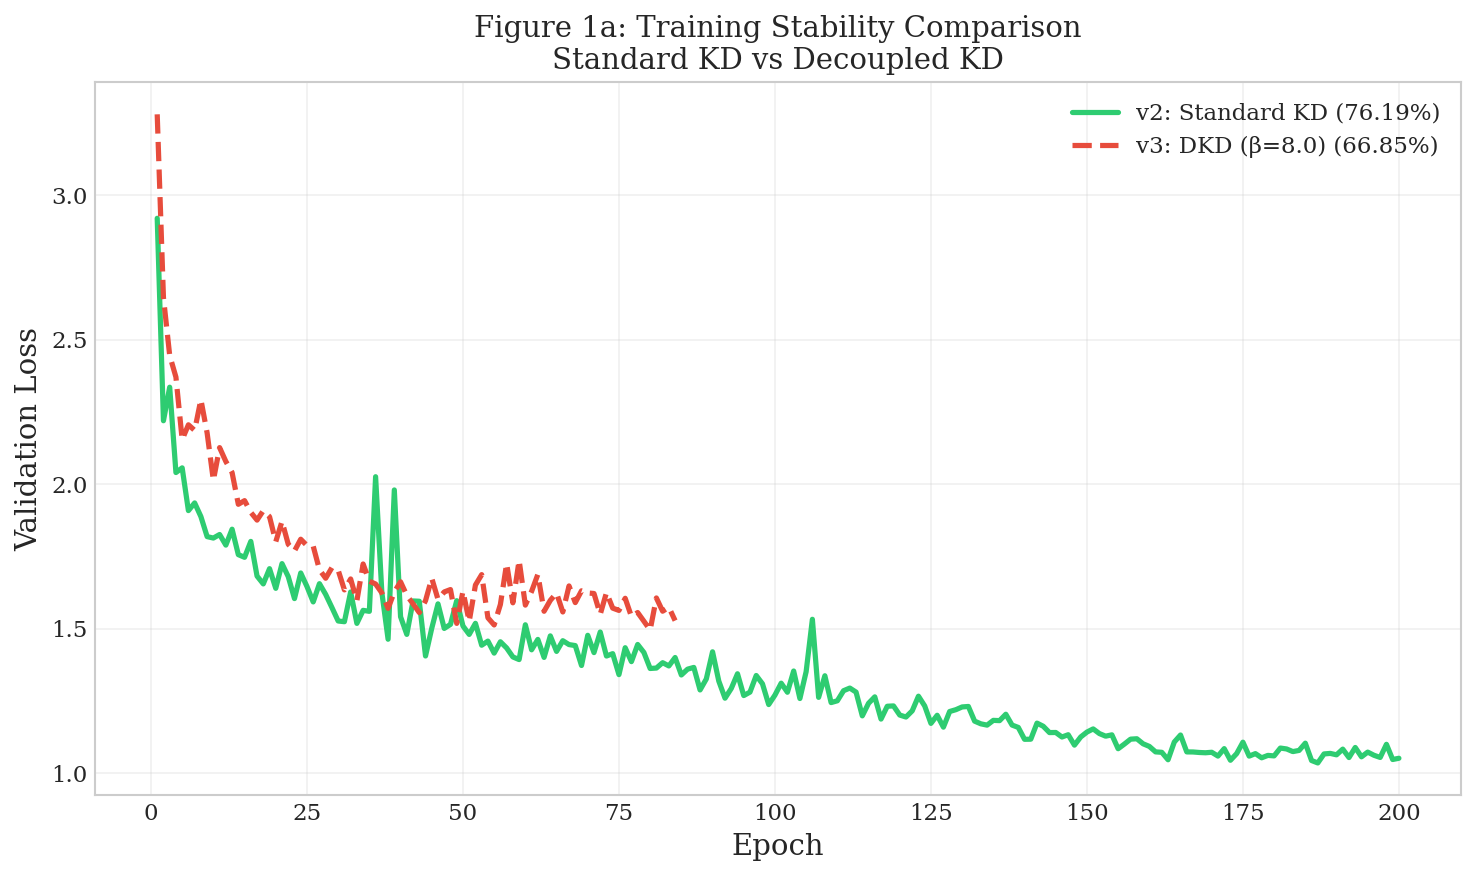

Saved: fig1a_loss_kd_vs_dkd.pdf


In [4]:
# Cell 4: Figure 1a - Standard KD vs DKD Loss
fig, ax = plt.subplots(figsize=(10, 6))

# Plot v2 (Standard KD) vs v3 (DKD)
for exp_id in ['v2_enhanced', 'v3_dkd_beta8']:
    if exp_id in experiments and 'history' in experiments[exp_id]:
        history = experiments[exp_id]['history']
        epochs = history['epoch']
        val_loss = history['val_loss']
        
        final_acc = get_accuracy(experiments[exp_id])
        label = f"{LABELS[exp_id]} ({final_acc:.2f}%)"
        
        linestyle = '-' if exp_id == 'v2_enhanced' else '--'
        ax.plot(epochs, val_loss, color=COLORS[exp_id], label=label, 
                linewidth=2.5, linestyle=linestyle)

ax.set_xlabel('Epoch')
ax.set_ylabel('Validation Loss')
ax.set_title('Figure 1a: Training Stability Comparison\nStandard KD vs Decoupled KD')
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'fig1a_loss_kd_vs_dkd.pdf')
plt.savefig(FIGURES_DIR / 'fig1a_loss_kd_vs_dkd.png')
plt.show()
print(f"Saved: fig1a_loss_kd_vs_dkd.pdf")

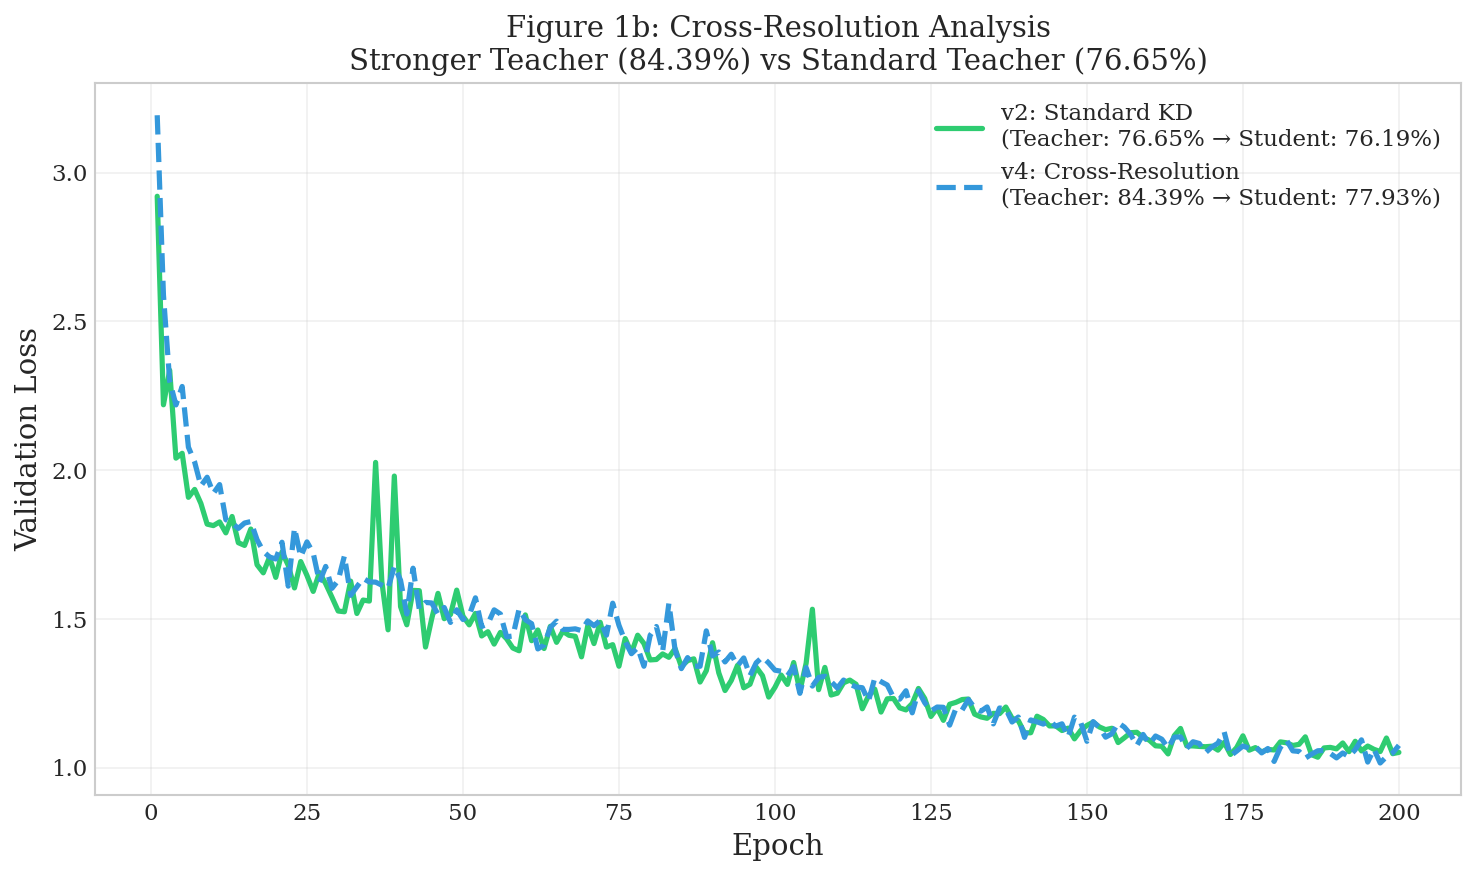

Saved: fig1b_cross_resolution.pdf


In [5]:
# Cell 5: Figure 1b - Cross-Resolution Analysis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot v2 vs v4 (Cross-Resolution)
for exp_id in ['v2_enhanced', 'v4_cross_res']:
    if exp_id in experiments and 'history' in experiments[exp_id]:
        history = experiments[exp_id]['history']
        epochs = history['epoch']
        val_loss = history['val_loss']
        
        results = experiments[exp_id]['final']['results']
        teacher_acc = results.get('teacher_accuracy', 0)
        student_acc = get_accuracy(experiments[exp_id])
        label = f"{LABELS[exp_id]}\n(Teacher: {teacher_acc:.2f}% → Student: {student_acc:.2f}%)"
        
        linestyle = '-' if exp_id == 'v2_enhanced' else '--'
        ax.plot(epochs, val_loss, color=COLORS[exp_id], label=label,
                linewidth=2.5, linestyle=linestyle)

ax.set_xlabel('Epoch')
ax.set_ylabel('Validation Loss')
ax.set_title('Figure 1b: Cross-Resolution Analysis\nStronger Teacher (84.39%) vs Standard Teacher (76.65%)')
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'fig1b_cross_resolution.pdf')
plt.savefig(FIGURES_DIR / 'fig1b_cross_resolution.png')
plt.show()
print(f"Saved: fig1b_cross_resolution.pdf")

## Figure 1c: Teacher Comparison (32x32 vs 64x64)


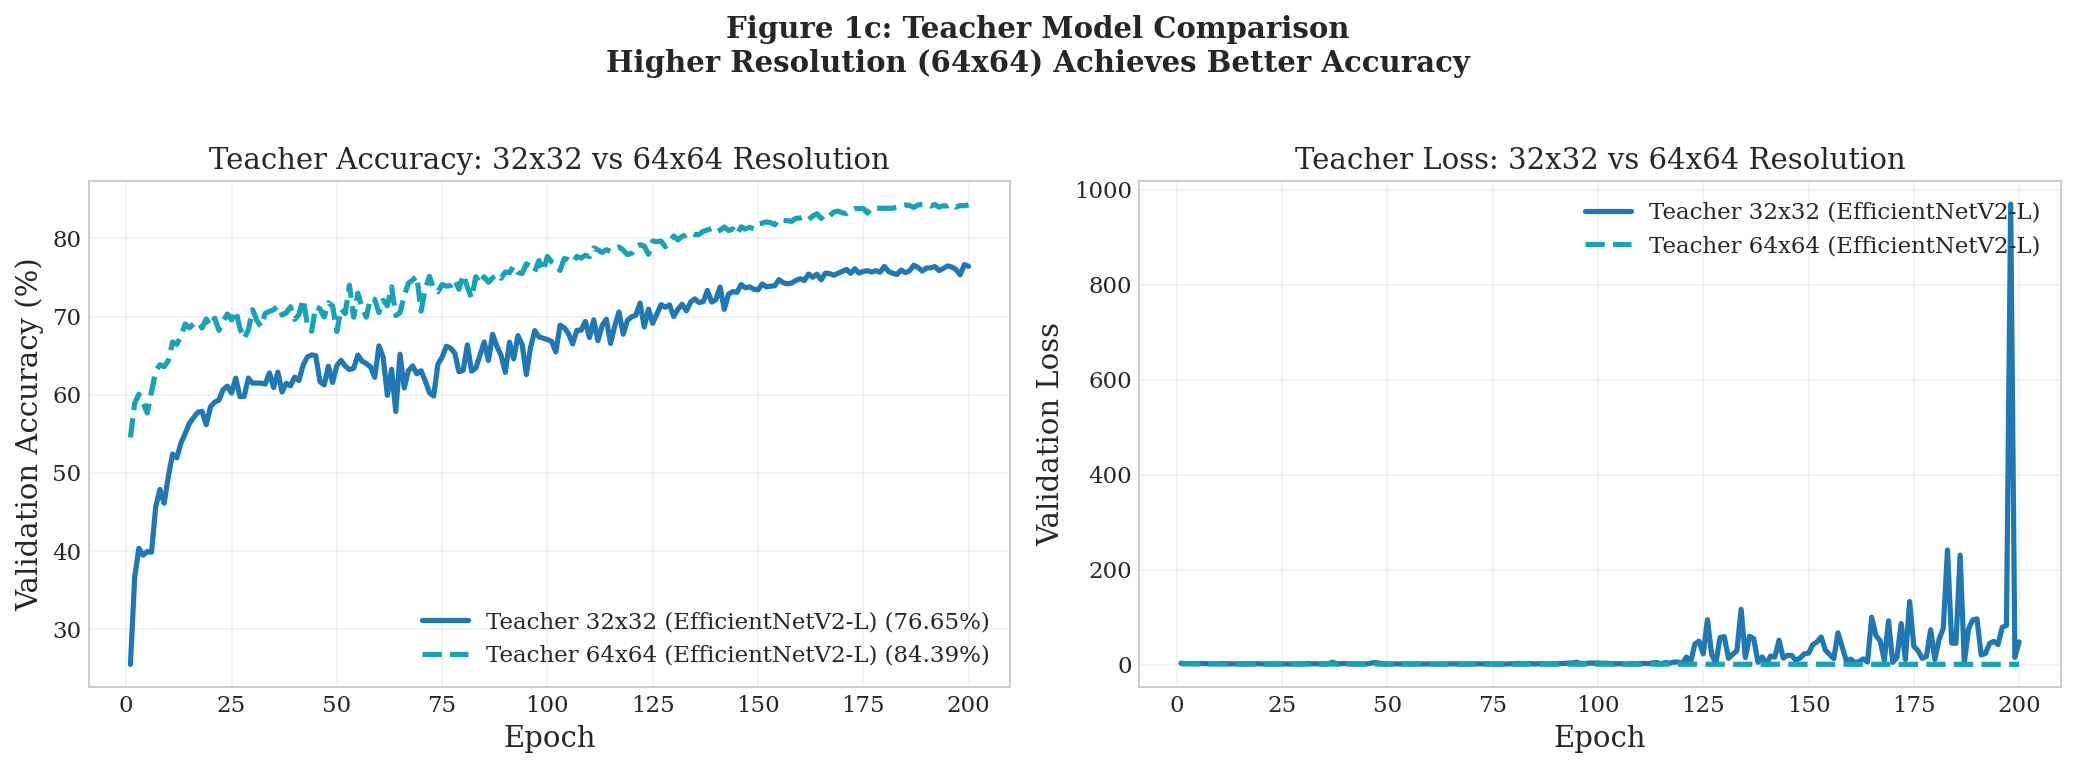

Saved: fig1c_teacher_comparison.pdf


In [6]:
# Cell 5b: Figure 1c - Teacher Comparison (32x32 vs 64x64)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Accuracy Comparison
ax1 = axes[0]
for teacher_id in ['teacher', 'teacher_v4']:
    if teacher_id in experiments and 'history' in experiments[teacher_id]:
        history = experiments[teacher_id]['history']
        epochs = history['epoch']
        val_acc = history['val_accuracy']
        
        final_acc = get_accuracy(experiments[teacher_id])
        label = f"{LABELS[teacher_id]} ({final_acc:.2f}%)"
        
        linestyle = '-' if teacher_id == 'teacher' else '--'
        ax1.plot(epochs, val_acc, color=COLORS[teacher_id], label=label,
                linewidth=2.5, linestyle=linestyle)

ax1.set_xlabel('Epoch')
ax1.set_ylabel('Validation Accuracy (%)')
ax1.set_title('Teacher Accuracy: 32x32 vs 64x64 Resolution')
ax1.legend(loc='lower right')
ax1.grid(True, alpha=0.3)

# Right: Loss Comparison
ax2 = axes[1]
for teacher_id in ['teacher', 'teacher_v4']:
    if teacher_id in experiments and 'history' in experiments[teacher_id]:
        history = experiments[teacher_id]['history']
        epochs = history['epoch']
        val_loss = history['val_loss']
        
        final_acc = get_accuracy(experiments[teacher_id])
        label = f"{LABELS[teacher_id]}"
        
        linestyle = '-' if teacher_id == 'teacher' else '--'
        ax2.plot(epochs, val_loss, color=COLORS[teacher_id], label=label,
                linewidth=2.5, linestyle=linestyle)

ax2.set_xlabel('Epoch')
ax2.set_ylabel('Validation Loss')
ax2.set_title('Teacher Loss: 32x32 vs 64x64 Resolution')
ax2.legend(loc='upper right')
ax2.grid(True, alpha=0.3)

plt.suptitle('Figure 1c: Teacher Model Comparison\nHigher Resolution (64x64) Achieves Better Accuracy', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(FIGURES_DIR / 'fig1c_teacher_comparison.pdf')
plt.savefig(FIGURES_DIR / 'fig1c_teacher_comparison.png')
plt.show()
print(f"Saved: fig1c_teacher_comparison.pdf")

## Figure 2: DKD Beta Comparison


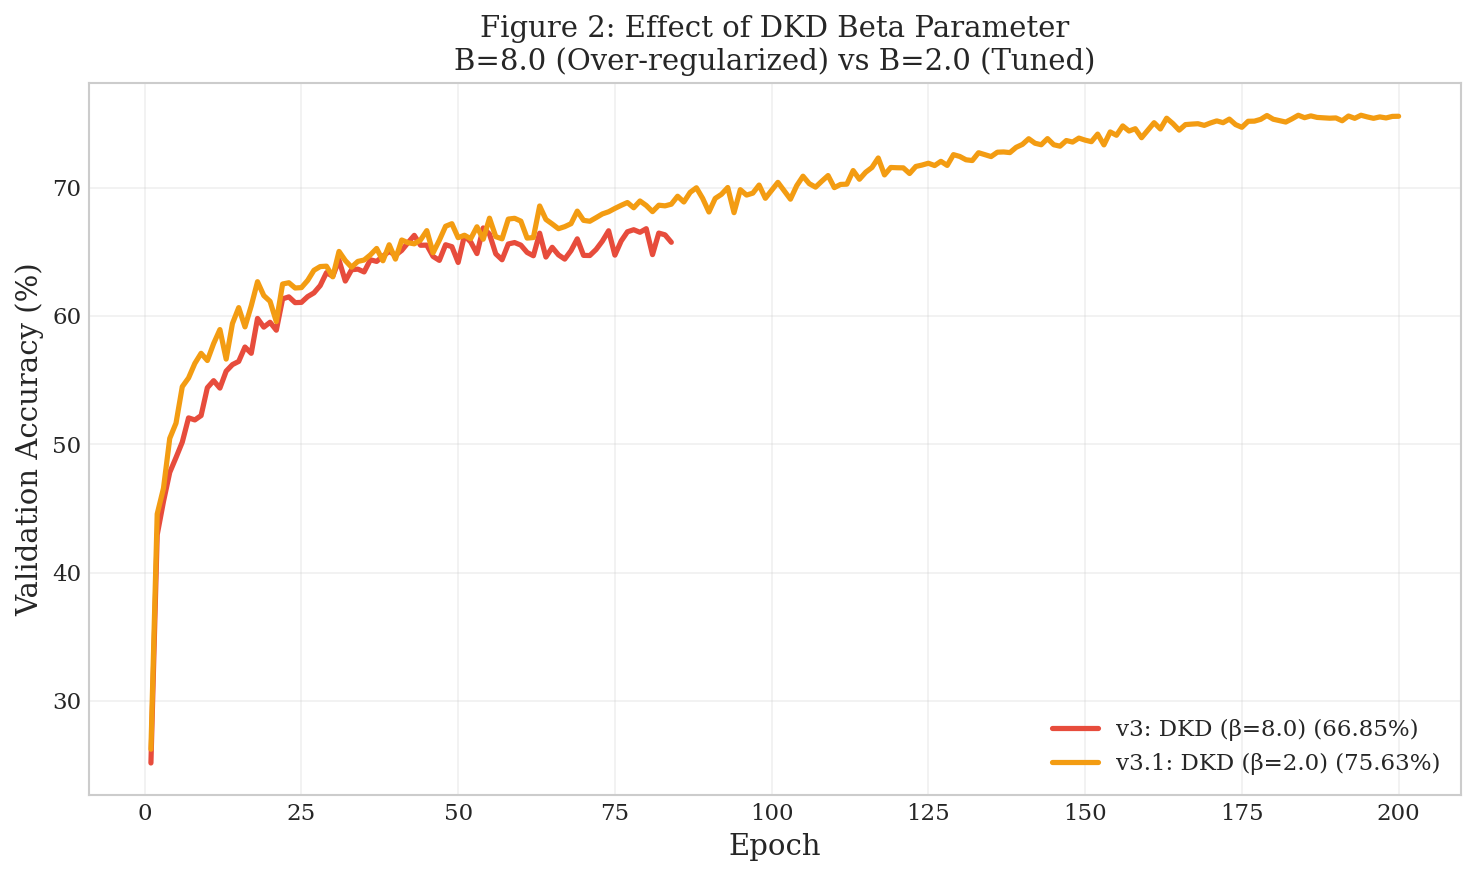

Saved: fig2_dkd_beta_comparison.pdf


In [7]:
# Cell 6: Figure 2 - DKD Beta Comparison
fig, ax = plt.subplots(figsize=(10, 6))

# Plot v3 vs v3.1 (DKD beta comparison)
for exp_id in ['v3_dkd_beta8', 'v3_1_dkd_beta2']:
    if exp_id in experiments and 'history' in experiments[exp_id]:
        history = experiments[exp_id]['history']
        epochs = history['epoch']
        val_acc = history['val_accuracy']
        
        final_acc = get_accuracy(experiments[exp_id])
        label = f"{LABELS[exp_id]} ({final_acc:.2f}%)"
        
        ax.plot(epochs, val_acc, color=COLORS[exp_id], label=label, linewidth=2.5)

ax.set_xlabel('Epoch')
ax.set_ylabel('Validation Accuracy (%)')
ax.set_title('Figure 2: Effect of DKD Beta Parameter\nB=8.0 (Over-regularized) vs B=2.0 (Tuned)')
ax.legend(loc='lower right')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'fig2_dkd_beta_comparison.pdf')
plt.savefig(FIGURES_DIR / 'fig2_dkd_beta_comparison.png')
plt.show()
print(f"Saved: fig2_dkd_beta_comparison.pdf")

## Figure 3: All Experiments Accuracy


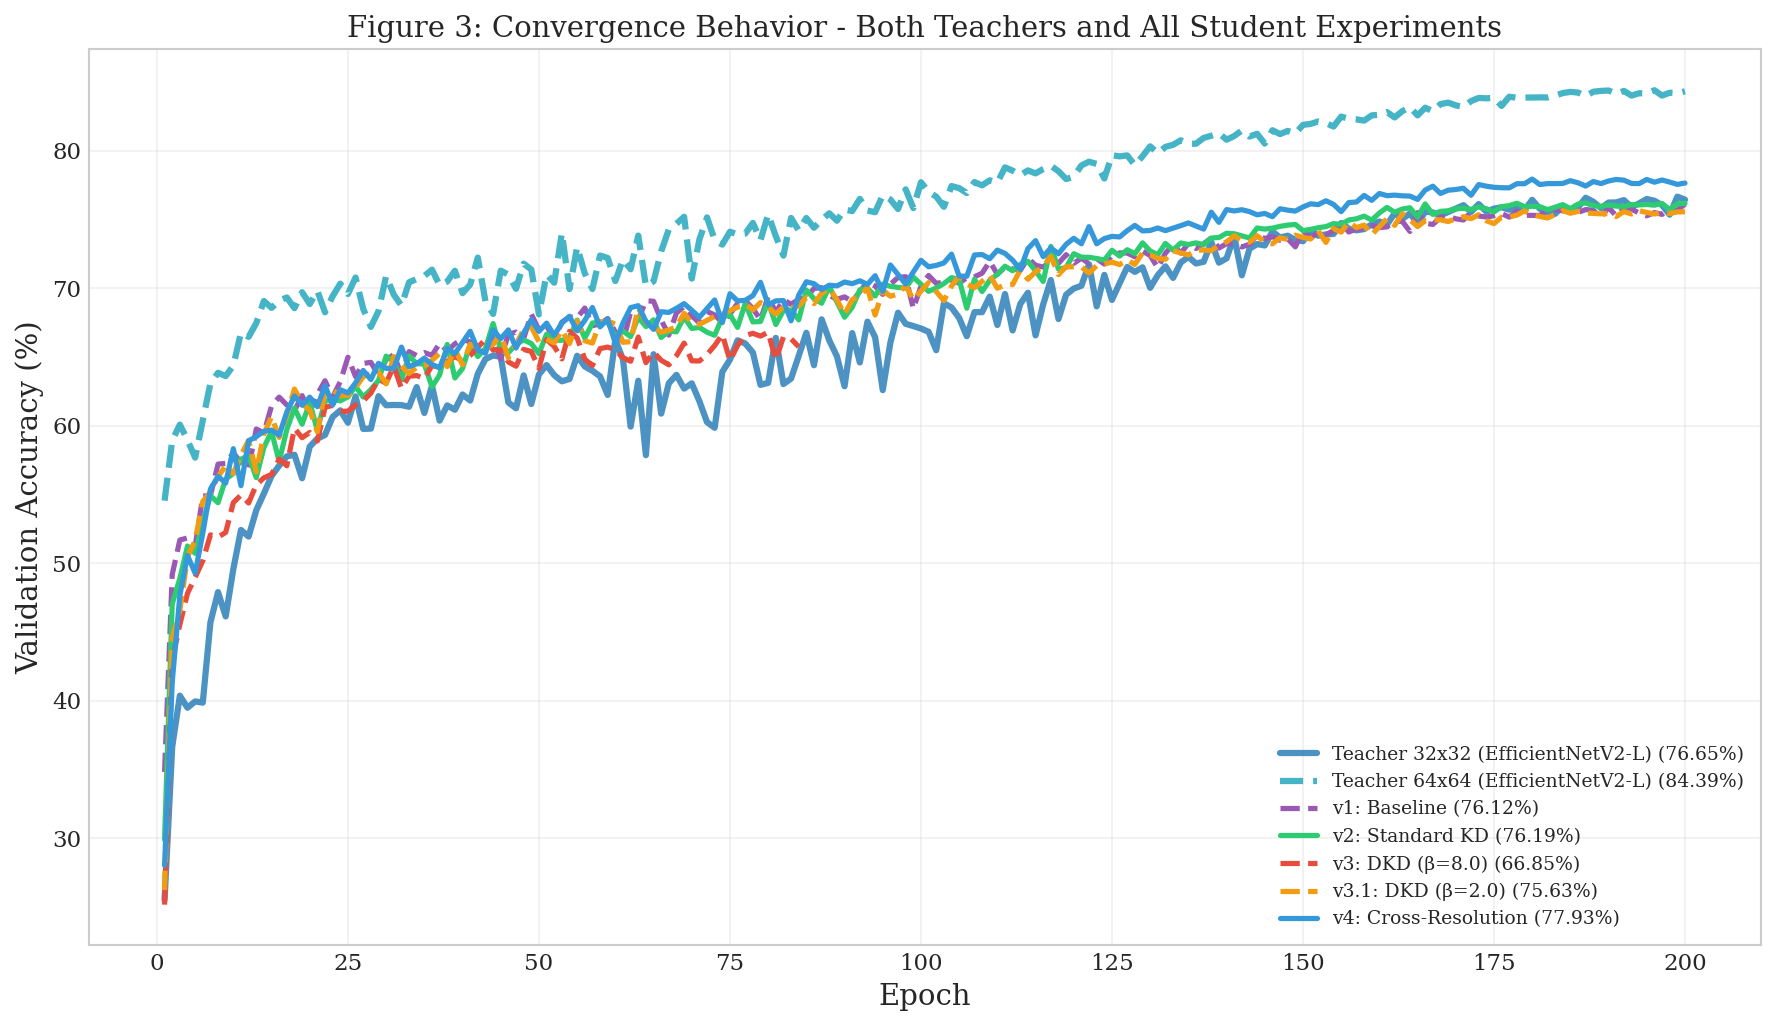

Saved: fig3_accuracy_all.pdf


In [8]:
# Cell 7: Figure 3 - All Experiments Accuracy Curves (Including Both Teachers)
fig, ax = plt.subplots(figsize=(12, 7))

# Plot Teacher 32x32
if 'teacher' in experiments and 'history' in experiments['teacher']:
    history = experiments['teacher']['history']
    epochs = history['epoch']
    val_acc = history['val_accuracy']
    
    final_acc = get_accuracy(experiments['teacher'])
    label = f"{LABELS['teacher']} ({final_acc:.2f}%)"
    
    ax.plot(epochs, val_acc, color=COLORS['teacher'], label=label,
            linewidth=3, linestyle='-', alpha=0.8)

# Plot Teacher V4 64x64
if 'teacher_v4' in experiments and 'history' in experiments['teacher_v4']:
    history = experiments['teacher_v4']['history']
    epochs = history['epoch']
    val_acc = history['val_accuracy']
    
    final_acc = get_accuracy(experiments['teacher_v4'])
    label = f"{LABELS['teacher_v4']} ({final_acc:.2f}%)"
    
    ax.plot(epochs, val_acc, color=COLORS['teacher_v4'], label=label,
            linewidth=3, linestyle='--', alpha=0.8)

# Plot Students
for exp_id in student_experiments:
    if exp_id in experiments and 'history' in experiments[exp_id]:
        history = experiments[exp_id]['history']
        epochs = history['epoch']
        val_acc = history['val_accuracy']
        
        final_acc = get_accuracy(experiments[exp_id])
        label = f"{LABELS[exp_id]} ({final_acc:.2f}%)"
        
        linestyle = '-' if exp_id in ['v2_enhanced', 'v4_cross_res'] else '--'
        ax.plot(epochs, val_acc, color=COLORS[exp_id], label=label,
                linewidth=2.5, linestyle=linestyle)

ax.set_xlabel('Epoch')
ax.set_ylabel('Validation Accuracy (%)')
ax.set_title('Figure 3: Convergence Behavior - Both Teachers and All Student Experiments')
ax.legend(loc='lower right', fontsize=9)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'fig3_accuracy_all.pdf')
plt.savefig(FIGURES_DIR / 'fig3_accuracy_all.png')
plt.show()
print(f"Saved: fig3_accuracy_all.pdf")

## Figure 4: Teacher Retention Bar Chart


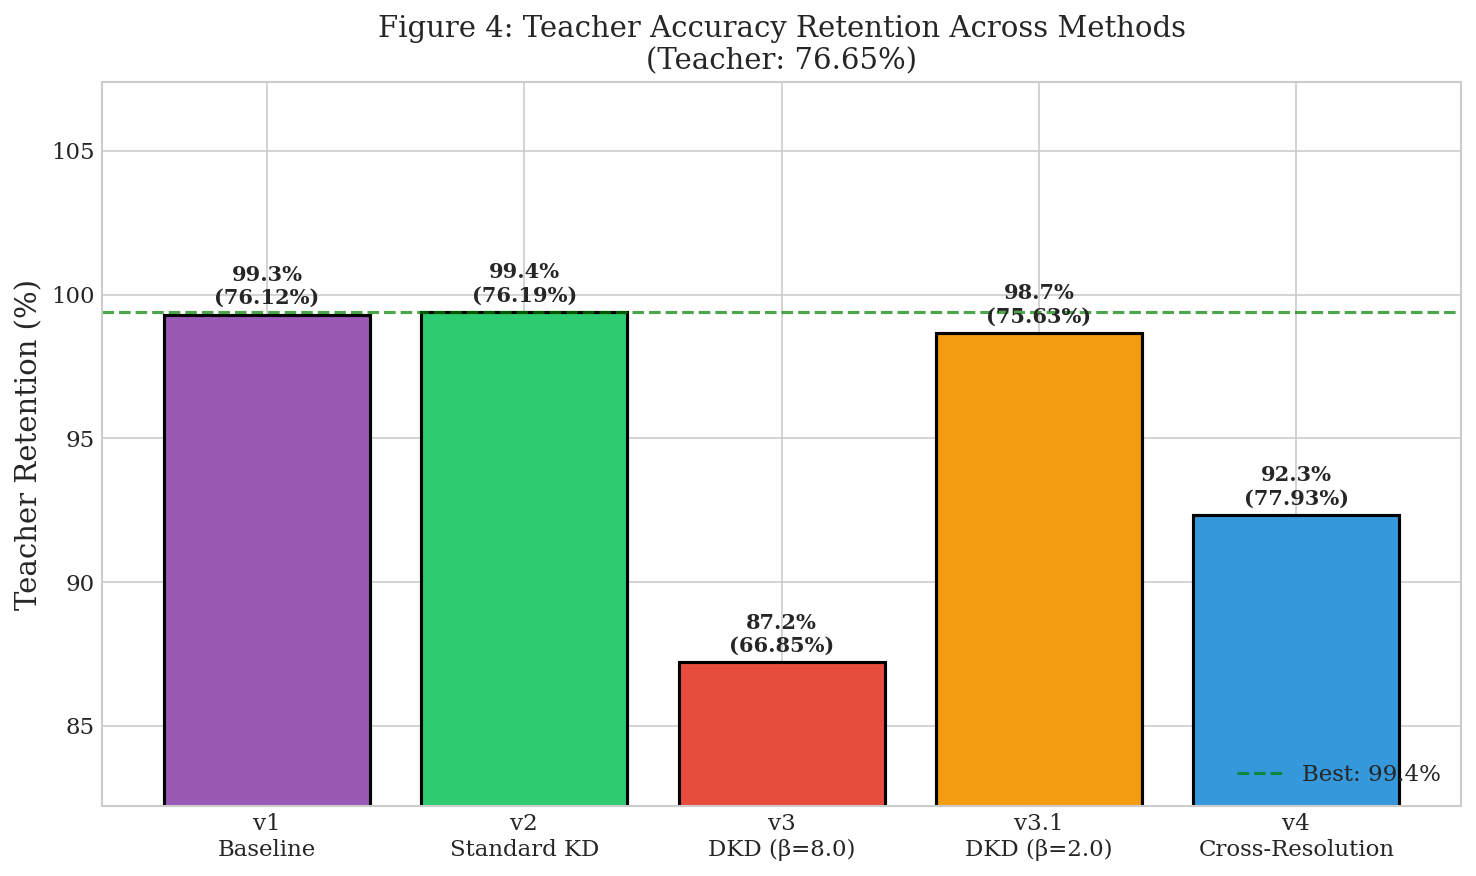

Saved: fig4_retention_bar.pdf


In [9]:
# Cell 8: Figure 4 - Retention Bar Chart
fig, ax = plt.subplots(figsize=(10, 6))

# Get teacher accuracy
teacher_acc = 0
if 'teacher' in experiments:
    teacher_acc = get_accuracy(experiments['teacher'])

# Prepare data
exp_names = []
retentions = []
student_accs = []
colors = []

for exp_id in student_experiments:
    if exp_id in experiments:
        student_acc = get_accuracy(experiments[exp_id])
        
        # Calculate retention (use teacher_accuracy from results if available)
        results = experiments[exp_id].get('final', {}).get('results', {})
        retention = results.get('retention_rate', 0)
        
        # If not available, calculate from teacher
        if retention == 0 and teacher_acc > 0:
            retention = (student_acc / teacher_acc) * 100
        
        exp_names.append(LABELS[exp_id].replace(': ', '\n'))
        retentions.append(retention)
        student_accs.append(student_acc)
        colors.append(COLORS[exp_id])

if retentions:
    # Create bar chart
    bars = ax.bar(exp_names, retentions, color=colors, edgecolor='black', linewidth=1.5)
    
    # Add value labels
    for bar, ret, acc in zip(bars, retentions, student_accs):
        height = bar.get_height()
        ax.annotate(f'{ret:.1f}%\n({acc:.2f}%)',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    ax.set_ylabel('Teacher Retention (%)')
    ax.set_title(f'Figure 4: Teacher Accuracy Retention Across Methods\n(Teacher: {teacher_acc:.2f}%)')
    ax.set_ylim(min(retentions) - 5, max(retentions) + 8)
    
    # Add best line
    best_retention = max(retentions)
    ax.axhline(y=best_retention, color='green', linestyle='--', alpha=0.7, 
               linewidth=1.5, label=f'Best: {best_retention:.1f}%')
    ax.legend(loc='lower right')
    
    plt.tight_layout()
    plt.savefig(FIGURES_DIR / 'fig4_retention_bar.pdf')
    plt.savefig(FIGURES_DIR / 'fig4_retention_bar.png')
    plt.show()
    print(f"Saved: fig4_retention_bar.pdf")
else:
    print("No student experiments found to create retention chart")

## Figure 5: Zoomed-in Convergence Analysis


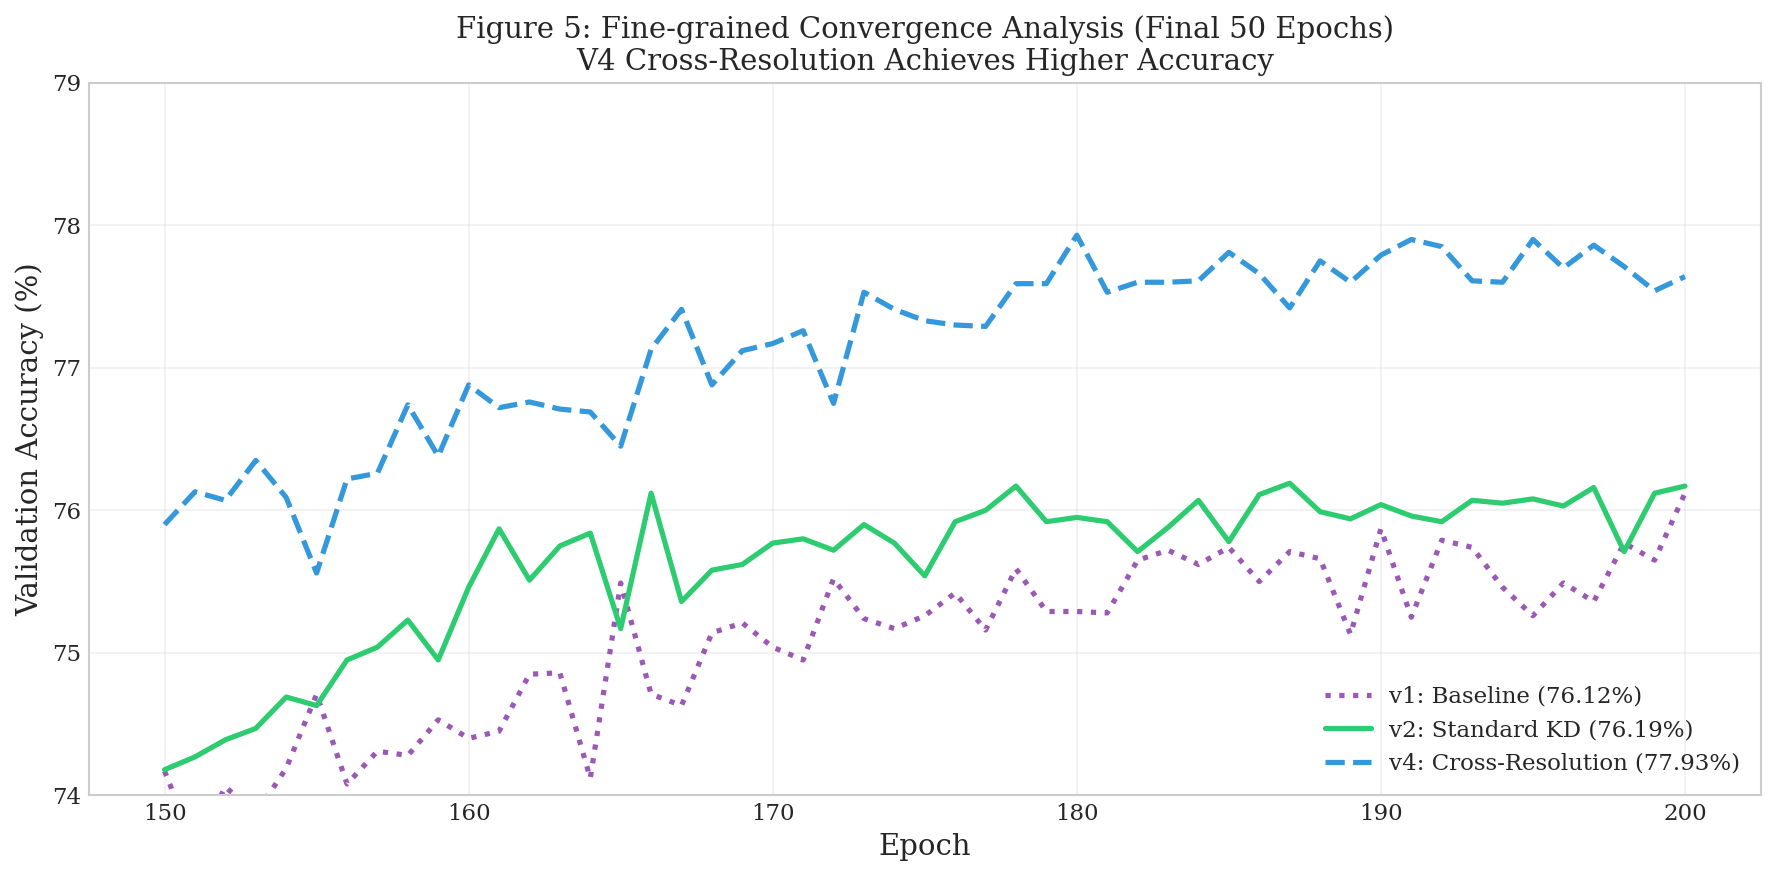

Saved: fig5_zoomed_convergence.pdf


In [10]:
# Cell 9: Figure 5 - Zoomed-in Convergence (Final 50 Epochs)
fig, ax = plt.subplots(figsize=(12, 6))

zoom_start_epoch = 150
experiments_to_plot = ['v1_baseline', 'v2_enhanced', 'v4_cross_res']

for exp_id in experiments_to_plot:
    if exp_id in experiments and 'history' in experiments[exp_id]:
        history = experiments[exp_id]['history']
        
        # Filter for last 50 epochs
        mask = history['epoch'] >= zoom_start_epoch
        epochs = history.loc[mask, 'epoch']
        val_acc = history.loc[mask, 'val_accuracy']
        
        final_acc = get_accuracy(experiments[exp_id])
        label = f"{LABELS[exp_id]} ({final_acc:.2f}%)"
        
        # Make lines distinct
        linestyle = '-'
        if exp_id == 'v1_baseline': linestyle = ':'
        elif exp_id == 'v4_cross_res': linestyle = '--'
        
        ax.plot(epochs, val_acc, color=COLORS[exp_id], label=label,
                linewidth=2.5, linestyle=linestyle)

ax.set_xlabel('Epoch')
ax.set_ylabel('Validation Accuracy (%)')
ax.set_title('Figure 5: Fine-grained Convergence Analysis (Final 50 Epochs)\nV4 Cross-Resolution Achieves Higher Accuracy')
ax.legend(loc='lower right')
ax.grid(True, alpha=0.3)
# Set y-axis limits to focus on the top performance range (updated for v4 results)
ax.set_ylim(bottom=74.0, top=79.0)

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'fig5_zoomed_convergence.pdf')
plt.savefig(FIGURES_DIR / 'fig5_zoomed_convergence.png')
plt.show()
print(f"Saved: fig5_zoomed_convergence.pdf")

## Figure 6: Cross-Resolution Distillation Mechanism


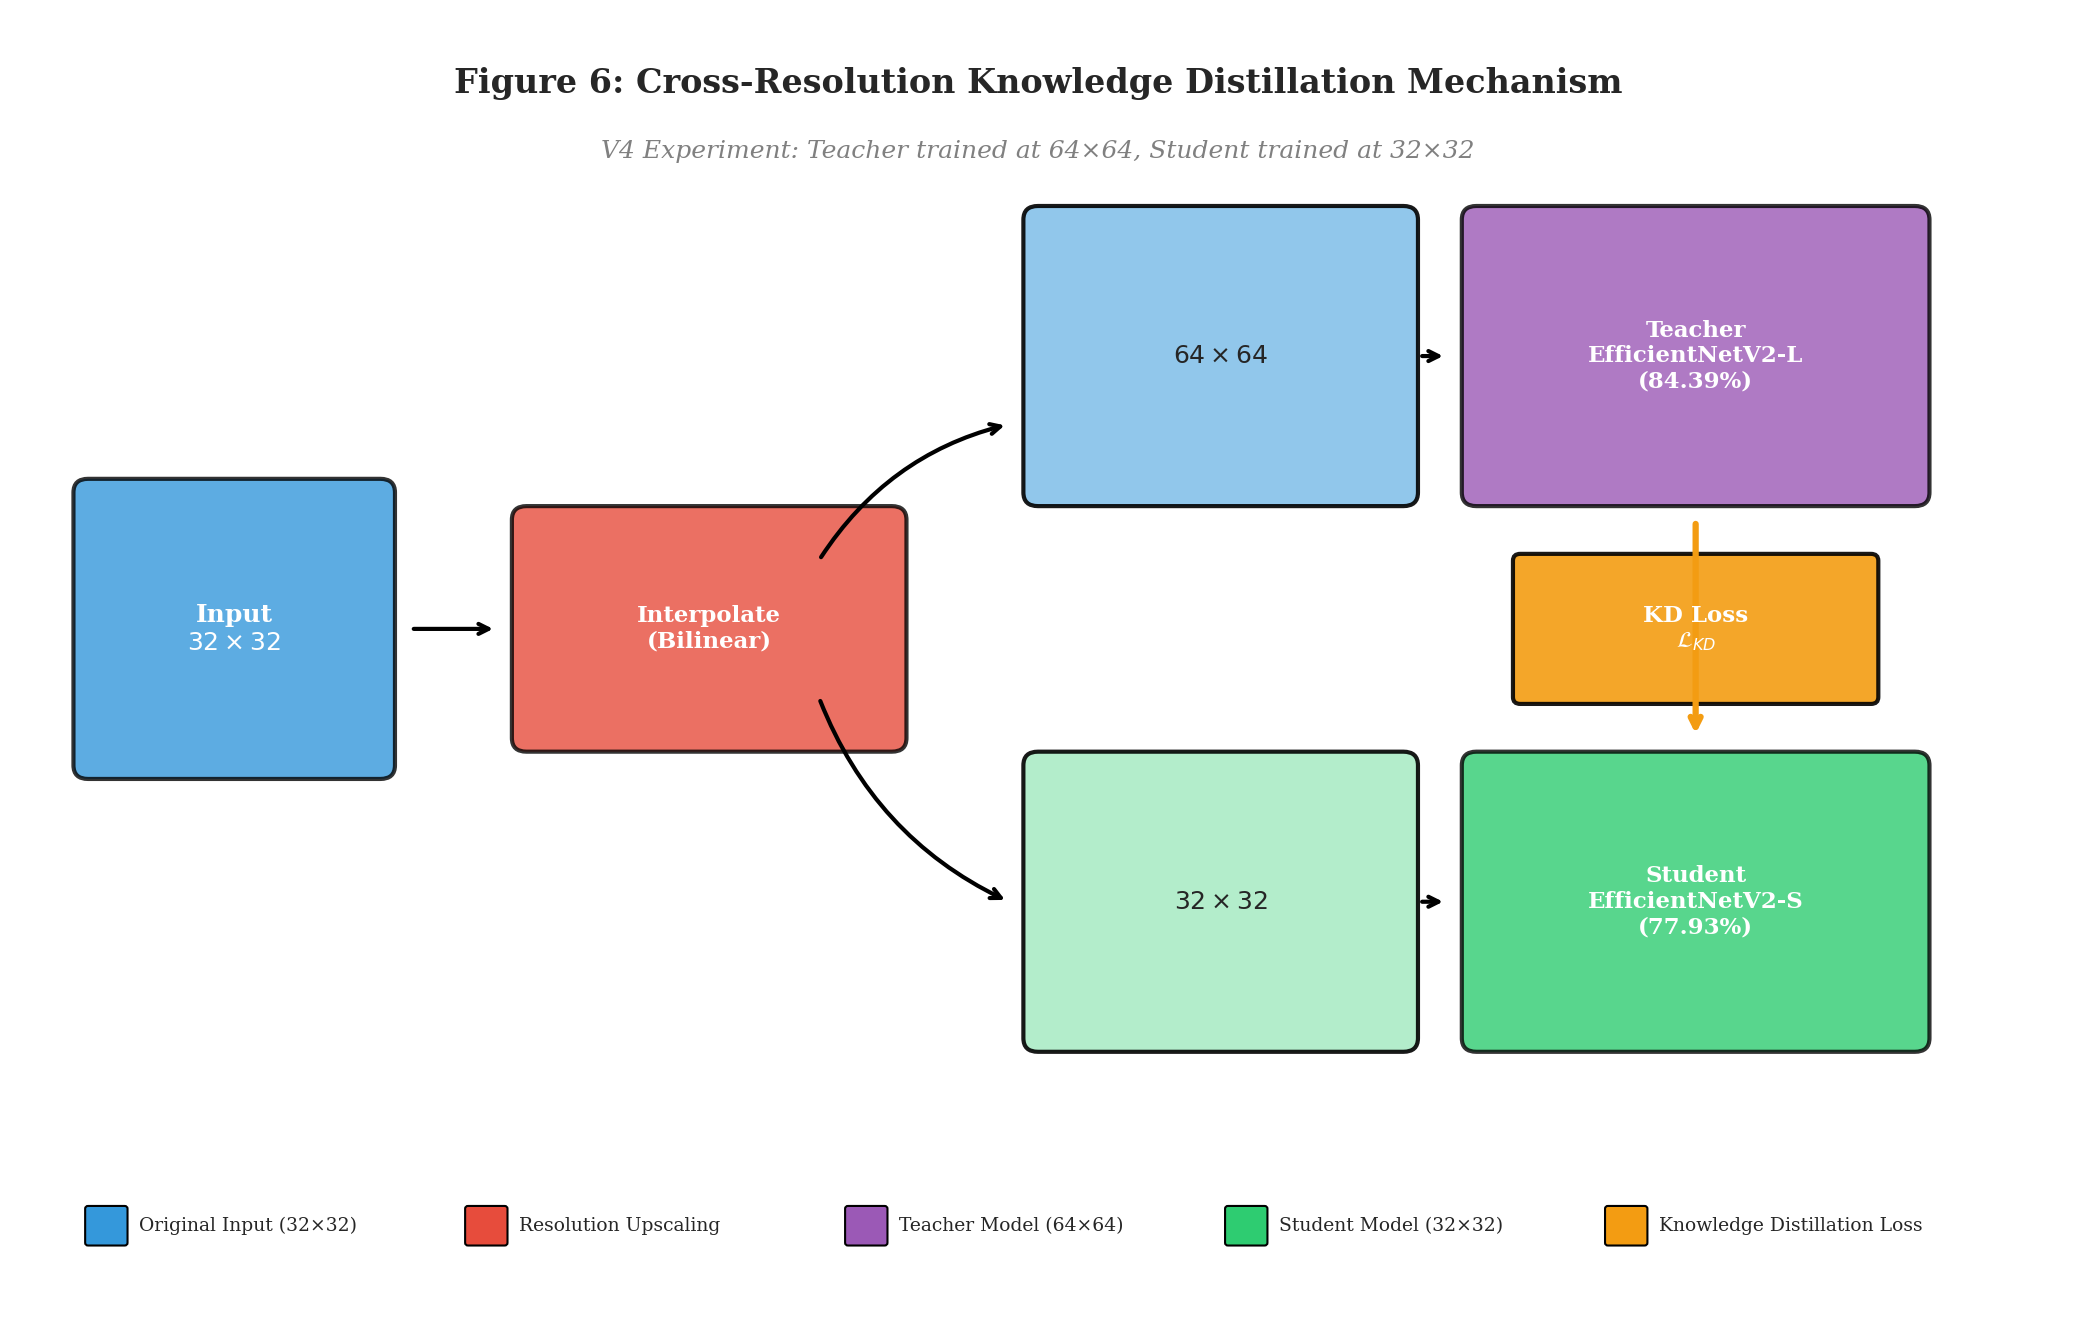

Saved: fig6_cross_resolution_mechanism.pdf


In [11]:
# Cell 10: Figure 6 - Cross-Resolution Distillation Mechanism Diagram
import matplotlib.patches as mpatches
from matplotlib.patches import FancyBboxPatch, FancyArrowPatch

fig, ax = plt.subplots(figsize=(14, 9))
ax.set_xlim(0, 14)
ax.set_ylim(-0.5, 9)
ax.axis('off')

# Colors
input_color = '#3498db'      # Blue
interpolate_color = '#e74c3c'  # Red
teacher_color = '#9b59b6'    # Purple
student_color = '#2ecc71'    # Green
kd_color = '#f39c12'         # Orange
output_color = '#1abc9c'     # Teal

# === Title (with more margin) ===
ax.text(7, 8.5, 'Figure 6: Cross-Resolution Knowledge Distillation Mechanism', 
        ha='center', va='center', fontsize=16, fontweight='bold')

# === Subtitle ===
ax.text(7, 8.0, 'V4 Experiment: Teacher trained at 64×64, Student trained at 32×32', 
        ha='center', va='center', fontsize=12, style='italic', color='gray')

# === Input Image (32x32) ===
input_box = FancyBboxPatch((0.5, 3.5), 2, 2, boxstyle="round,pad=0.1", 
                            facecolor=input_color, edgecolor='black', linewidth=2, alpha=0.8)
ax.add_patch(input_box)
ax.text(1.5, 4.5, 'Input\n$32 \\times 32$', ha='center', va='center', fontsize=12, fontweight='bold', color='white')

# === Arrow: Input to Interpolate ===
ax.annotate('', xy=(3.3, 4.5), xytext=(2.7, 4.5),
            arrowprops=dict(arrowstyle='->', color='black', lw=2))

# === Interpolate Box ===
interp_box = FancyBboxPatch((3.5, 3.7), 2.5, 1.6, boxstyle="round,pad=0.1",
                             facecolor=interpolate_color, edgecolor='black', linewidth=2, alpha=0.8)
ax.add_patch(interp_box)
ax.text(4.75, 4.5, 'Interpolate\n(Bilinear)', ha='center', va='center', fontsize=11, fontweight='bold', color='white')

# === Arrow: Interpolate to Teacher Input (64x64) ===
ax.annotate('', xy=(6.8, 6), xytext=(5.5, 5),
            arrowprops=dict(arrowstyle='->', color='black', lw=2, connectionstyle="arc3,rad=-0.2"))

# === Teacher Input (64x64) ===
teacher_input_box = FancyBboxPatch((7, 5.5), 2.5, 2, boxstyle="round,pad=0.1",
                                    facecolor='#85c1e9', edgecolor='black', linewidth=2, alpha=0.9)
ax.add_patch(teacher_input_box)
ax.text(8.25, 6.5, '$64 \\times 64$', ha='center', va='center', fontsize=12, fontweight='bold')

# === Teacher Model ===
teacher_box = FancyBboxPatch((10, 5.5), 3, 2, boxstyle="round,pad=0.1",
                              facecolor=teacher_color, edgecolor='black', linewidth=2, alpha=0.8)
ax.add_patch(teacher_box)
ax.text(11.5, 6.5, 'Teacher\nEfficientNetV2-L\n(84.39%)', ha='center', va='center', 
        fontsize=11, fontweight='bold', color='white')

# === Arrow: Teacher Input to Teacher ===
ax.annotate('', xy=(9.8, 6.5), xytext=(9.6, 6.5),
            arrowprops=dict(arrowstyle='->', color='black', lw=2))

# === Arrow: Input to Student (direct path) ===
ax.annotate('', xy=(6.8, 2.5), xytext=(5.5, 4),
            arrowprops=dict(arrowstyle='->', color='black', lw=2, connectionstyle="arc3,rad=0.2"))

# === Student Input (32x32) ===
student_input_box = FancyBboxPatch((7, 1.5), 2.5, 2, boxstyle="round,pad=0.1",
                                    facecolor='#abebc6', edgecolor='black', linewidth=2, alpha=0.9)
ax.add_patch(student_input_box)
ax.text(8.25, 2.5, '$32 \\times 32$', ha='center', va='center', fontsize=12, fontweight='bold')

# === Student Model ===
student_box = FancyBboxPatch((10, 1.5), 3, 2, boxstyle="round,pad=0.1",
                              facecolor=student_color, edgecolor='black', linewidth=2, alpha=0.8)
ax.add_patch(student_box)
ax.text(11.5, 2.5, 'Student\nEfficientNetV2-S\n(77.93%)', ha='center', va='center', 
        fontsize=11, fontweight='bold', color='white')

# === Arrow: Student Input to Student ===
ax.annotate('', xy=(9.8, 2.5), xytext=(9.6, 2.5),
            arrowprops=dict(arrowstyle='->', color='black', lw=2))

# === KD Loss Arrow (Teacher to Student) ===
ax.annotate('', xy=(11.5, 3.7), xytext=(11.5, 5.3),
            arrowprops=dict(arrowstyle='->', color=kd_color, lw=3, 
                           connectionstyle="arc3,rad=0"))

# === KD Loss Label ===
kd_box = FancyBboxPatch((10.3, 4), 2.4, 1, boxstyle="round,pad=0.05",
                         facecolor=kd_color, edgecolor='black', linewidth=2, alpha=0.9)
ax.add_patch(kd_box)
ax.text(11.5, 4.5, 'KD Loss\n$\\mathcal{L}_{KD}$', ha='center', va='center', 
        fontsize=11, fontweight='bold', color='white')

# === Legend (smaller boxes, better organized) ===
legend_y = 0
box_size = 0.25  # Smaller boxes

# Create legend items
legend_items = [
    (input_color, 'Original Input (32×32)'),
    (interpolate_color, 'Resolution Upscaling'),
    (teacher_color, 'Teacher Model (64×64)'),
    (student_color, 'Student Model (32×32)'),
    (kd_color, 'Knowledge Distillation Loss'),
]

# Calculate spacing
total_width = 13
item_width = total_width / len(legend_items)
start_x = 0.5

for i, (color, label) in enumerate(legend_items):
    x = start_x + i * item_width
    # Small color box
    ax.add_patch(FancyBboxPatch((x, legend_y), box_size, box_size, 
                                 boxstyle="round,pad=0.02",
                                 facecolor=color, edgecolor='black', linewidth=1))
    # Label text
    ax.text(x + box_size + 0.1, legend_y + box_size/2, label, 
            fontsize=9, va='center', ha='left')

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'fig6_cross_resolution_mechanism.pdf', bbox_inches='tight')
plt.savefig(FIGURES_DIR / 'fig6_cross_resolution_mechanism.png', bbox_inches='tight', dpi=300)
plt.show()
print(f"Saved: fig6_cross_resolution_mechanism.pdf")

## Summary


In [12]:
# Cell 11: List Generated Figures
print("=" * 60)
print("GENERATED FIGURES")
print("=" * 60)

for f in sorted(FIGURES_DIR.glob("*.pdf")):
    size_kb = f.stat().st_size / 1024
    print(f"  {f.name} ({size_kb:.1f} KB)")

print(f"\nTotal: {len(list(FIGURES_DIR.glob('*.pdf')))} PDF figures")
print(f"Location: {FIGURES_DIR}")

GENERATED FIGURES
  fig1a_loss_kd_vs_dkd.pdf (20.9 KB)
  fig1b_cross_resolution.pdf (22.1 KB)
  fig1c_teacher_comparison.pdf (34.0 KB)
  fig2_dkd_beta_comparison.pdf (21.1 KB)
  fig3_accuracy_all.pdf (30.1 KB)
  fig4_retention_bar.pdf (24.3 KB)
  fig5_zoomed_convergence.pdf (19.0 KB)
  fig6_cross_resolution_mechanism.pdf (48.4 KB)

Total: 8 PDF figures
Location: d:\Projects\KnowledgeDistillation\code_v2_32\figures
